## Solução para o jogo

Modelo de Dou et al., 2020.



In [1]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
#libraries
import numpy as np
from numba import jit, jitclass, njit, float64,  int32, char #para otimizar as funções
import numba as nb
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from scipy.stats import beta

from random import uniform #para a draw da uniforme(0,1)
import math

import time #tempo de computação


In [3]:
#abre o site
import webbrowser

# webbrowser.open('https://www.labri.fr/perso/nrougier/from-python-to-numpy/')

### Passo 0: definindo comandos do latex para facilitar a escrita

Aqui também podemos descrever as funções do jogo

$%conjunto de informações de s em t$
$\newcommand{\Is}[1]{\theta_{s{#1}}, l_{s{#1}}, l_{j{#1}}}$
$%macros para facilitar a escrita de funções valor$


$%conjunto de informações de j em t$
$\newcommand{\Ij}[1]{\theta_{j{#1}}, l_{s{#1}}, l_{j{#1}}}$

$%função valor de s em t$
$\newcommand{\Ws}[1]{ W_{s{#1}} ( \Is{{#1}}) }$

$%função valor de j em t$
$\newcommand{\Wj}[1]{ W_{j{#1}} ( \Ij{{#1}}) }$

$%operador esperança de s em t. 2 argumentos: o primeiro é o período e o segundo é o termo que ela tira a esperança$

$\newcommand{\Es}[2]{\mathbb{E_{#1}^{s} \big[ {#2}  \mid ( \Is{#1} )    \big] }}$

$%minúsculo não mostra o conjunto de informação$
$\newcommand{\es}[2]{\mathbb{E_{#1}^{s} \big[ {#2}  \big] }}$

$%minúsculo não mostra o conjunto de informação$
$%final b de big para aumentar os parênteses$
$\newcommand{\esb}[2]{\mathbb{E_{#1}^{s} \bigg[ {#2}  \bigg] }}$

$%operador esperança de j em t. 2 argumentos: o primeiro é o período e o segundo é o termo que ela tira a esperança$

$\newcommand{\Ej}[2]{\mathbb{E_{#1}^{j} \big[ {#2}  \mid ( \Ij{#1} )    \big] }}$

$%minúsculo não mostra o conjunto de informação$
$\newcommand{\ej}[2]{\mathbb{E_{#1}^{j} \big[ {#2}  \big] }}$

$%minúsculo não mostra o conjunto de informação$
$%final b para aumentar os parênteses$
$\newcommand{\ejb}[2]{\mathbb{E_{#1}^{j} \bigg[ {#2}  \bigg] }}$


$%comando para usar o máximo com chaves grandes$
$\newcommand{\maximo}[1]{\max \bigg\{ #1 \bigg\}}$


In [4]:
#parâmetros do jogo, apenas para ilustração a princípio
#coloquei os mesmos parãmetros dos autores (Tabela 4). No caso dos dados, usei as médias (Panel B)





μ = 4.566 #número de meses entre períodos, não entendi onde entra ainda
ρ = 0.884 # (1 - ρ) é a taxa de depreciação da empresa a cada período
β = 9.84 #usamos aqui a distribuição Uniforme, depois vamos mudar isto
c0 = 0.044 #custo fixo de ir para a corte
c1 = 0.015 #custo variável de ir para a corte


θ_s0 = 0.28 #habilidade inicial de s
θ_j0 = 0.36 #habilidade inicial de j

In [5]:
#informações que virão dos dados

#valores médios de L, Dj e Ds. Arredondei para duas casas decimais ao simular o modelo
# 0.2493718592964824
# 0.35113065326633164
# 0.27701005025125625



λj = 0.346 #probabilidade de j propor a cada turno. Não precisaremos estimar, isso virá dos dados

Vmax = 1
L = 0.25
# L_s = 10
# L_j = 10

#valores da dívida de cada jogador (virá dos dados, aqui é exemplo):
Dj = 0.35
Ds = 0.28

### Passo 1: número máximo de turnos

Calculado com base nos parâmetros


t é tal que

$$ \rho^{t-1} V_{max} = L$$


$$ t = \frac{log(L) - log(V_{max})} {log(\rho)} +1 $$

In [6]:
#função para calcular o máximo de turnos do jogo
def maximo_de_turnos(ρ, Vmax, L):
    
    T = (math.log(L) - math.log(Vmax))/math.log(ρ) + 1
    
    #arredonda para baixo porque queremos o último período no qual o valor de continuação é maior ou igual ao de liquidação
    T = math.floor(T)
        
    return T

T = maximo_de_turnos(ρ, Vmax, L)

In [7]:
#valor máximo de reorganização da firma a cada período


#sequência de valores da firma para cada período
#tem que deixar como dtype = np.float para pegar valores decimais

def Vt(Vmax, T, ρ):
    
    

    V = np.empty(T, dtype=np.float)

    for t in range(T):
        
        #no período t = 0, ela é o Vmax. E no período t = 1, também, pois não depreciou ainda

        if(t == 0):
            V[t] = Vmax

        else:
            V[t] = ρ**(t-1) * Vmax
            
    return V

V = Vt(Vmax, T, ρ)

### Passo 2: Definir os arrays para guardar as funções valor de cada período

São:

* 100 slots para habilidade do jogador

* 100 slots para o lower bound do adversário

* 100 slots para o lower bound do próprio jogador no próximo período

* 2 slots para dizer se o jogador está propondo ou não
    
* T slots para marcar o período da função valor



In [8]:
#slots para cada habilidade
grid_size = 100


#a vantagem de colocar os dados assim é que se eu quiser teta_s = 0.115, basta procurar θs_vals[114]
θs_vals = np.linspace(0.01, 1, grid_size) 
θj_vals  = np.linspace(0.01, 1, grid_size)  


#vetores dos lower bounds são similares aos das habilidades
ℓs_vals = θs_vals
ℓj_vals = θj_vals


#teste
# θs_vals[99 - 1]


#checando o tamanho
# len(θj_vals)

In [9]:
#valor de liquidação


#a dívida total é sempre a soma das dívidas
D = Ds + Dj

#o custo total é uma função do tempo

@njit
def C_func(t):
    if(t == 0):
        return 0
    else:
        Ct = c0 * D + c1 * t * D

        return Ct

#e os valores de liquidação também são função do tempo

#versão vetorizada
def Ct(T):
    
    C = np.empty(T, dtype=np.float)

    for t in range(T):
        
        #no período t = 0, o custo é zero

        if(t == 0):
            C[0] = 0

        else:
            C[t] = c0 * D + c1 * t * D
            
    return C

#C é um vetor de mesma dimensão do número de turnos
C = Ct(T)



    
#test
# C(1)

In [10]:
#valores de liquidação
@njit
def s_L(t):
    
    Ls = min(L - C_func(t), Ds)
    
    return Ls

@njit
def j_L(t):
    
    Lj = min(L - C_func(t) - s_L(t), Dj)
    
    return Lj

In [11]:
#funções para achar os valores nas matrizes
@njit
def find(y):
    
    x = 100*y - 1
    
    #transformando em int para usar como índice nas matrizes
    x = int(x)
    
    return x

#test
# find(0.9)

#versão vetorizada
@njit
def vfind(y):
#     return np.array(100*y -1, dtype = np.int32)
    return np.subtract(np.multiply(100, y), 1).astype(np.int16)
#testando
# vfind(θs_vals)

#### Passo 3: fazer o cálculo das funções valor em T-1, T-2, ..., 1.

### Função para tirar um draw da distribuição Beta


Vamos usar o método da amostragem da inversa da CDF (https://en.wikipedia.org/wiki/Inverse_transform_sampling_method). Outra referência que usei foi: https://blogs.sas.com/content/iml/2013/07/22/the-inverse-cdf-method.html#:~:text=The%20exponential%20distribution%20has%20probability,log(1%E2%80%93u).

A CDF da Beta é 

$$ F_{\beta} ( \theta_{t+1} \mid \theta_{t} ) = 1 - \frac{ (1 - \theta_{t+1})^\beta}{ (1 - \theta_{t})^\beta }, \, \, \theta_{t} \leq \theta_{t+1} \leq 1, \, \beta \geq 1$$

Para invertê-la, basta procurarmos o valor de x tal que $F(x) = u$, onde u é uma retirada da distribuição Uniforme(0,1).

Fazendo os cálculos, esse valor de x é (ou $\theta_{t+1}$, no caso)


$$ \theta_{t+1} =  1 - exp \bigg\{ \frac{1}{\beta} \big[  log (1 - u) + \beta * log(1 - \theta_{t}) \big] \bigg\} $$


In [12]:
#código para tirar draw da distribuição beta
@njit
def draw_beta(info_hoje):
    
    
    #se for igual a 1, retorna 1. Não usei a fórmula da inversa CDF porque teríamos log (0)
    if(info_hoje == 1):
        return 1
    else:
    
        u = uniform(0, 1)
        x = 1 - math.exp( (1/β) * (math.log(1-u) + β*math.log(1-info_hoje)) )

        return x




# testando

# draw_beta(0.5)



# #teste com draw da função UNIFORME
# def draw_beta(info_hoje):
#     u = uniform(info_hoje, 1)
#     return u


# # testando
# draw_beta(0.99)

### Função para tirar o valor esperado do teta amanhã, dada a informação hoje.

Usamos a forma fechada, baseada na esperança de uma variável aleatória truncada: https://en.wikipedia.org/wiki/Truncated_distribution



$$ \mathbb{E} \big[ X \mid X > y \big] =  \frac{\int_{y}^{\infty}  x g(x) dx} {1 - F(y)} $$


Onde:

* $f(x)$ é a pdf da Beta, sem truncar. No caso, usamos a = 1 e b = $\beta$
* $ g(x) = f(x)$ sempre que $x > y$ e 0 caso contrário
* $F(y)$ é a CDF da Beta, sem truncar, avaliada em y


Em nosso caso, y será a informação que temos hoje para formar a expectativa sobre a habilidade amanhã. Na prática, y será ou a habilidade do credor no período atual $\theta_{k,t}, k \in \{s,j\}$ ou o lower bound da habilidade do credor adversário no período atual $l_{k,t}$.

Ilustraremos a fórmula usando $l_{t}$:

<!-- 
$$ \mathbb{E} \big[ \theta_{t+1} \mid \theta_{t+1} > l_t \big] =  \frac{ l_t (1 - l_t)^\beta + \frac{(1-l_t)^{\beta+1} }{(\beta+1)} } {1 - (1 - l_t)^\beta} $$ -->



$$ \mathbb{E} \big[ \theta_{t+1} \mid \theta_{t+1} > l_t \big] =  \frac{ l_t (1 - l_t)^\beta + (1-l_t)^{\beta+1}(\beta+1)^{-1} } {(1 - l_t)^{\beta} } $$



In [13]:
@njit
def expec_beta(info_hoje):
    
    #retorna 1 se a info_hoje for 1. A CDF não suporta 1
    if info_hoje == 1:
        return 1
    else:
        num = info_hoje * (1 - info_hoje)**β + ((1-info_hoje)**(β+1))/(β+1)

        denom = (1-info_hoje)**(β)

        return round(num/denom,2)
    

# testando, com beta = 1 e lt = 0.5, deve achar 0.75


# expec_beta(0.5)


# #para os outros valores, não pode ser superior a 1. E tem que ser crescente
# expec_beta(0.3)

# expec_beta(0.99)
# expec_beta(1)

#vetorizando
vexpec = np.vectorize(expec_beta)

#tentar com numba vectorize

In [14]:
#binning da pdf beta
#discretização da variável.

#ALTERNATIVA: dividir o range em 100 espaços iguais, cada espaço é um bin

#gerando 1000 draws

def bin(info_hoje, ndraws):
    
    beta_vals = []

    for k in range(ndraws):
        beta_amanha = draw_beta(info_hoje)

        beta_vals.append(beta_amanha)
    
    #cria os bins e conta quantos valores estão dentro deles
    teta_bins = np.zeros(len(θj_vals))  
    
    for t in range(len(teta_bins)):
        
        #ajustando os bins iniciais e final
        if(t==0):
            pre = 0
        else:
            pre = (θj_vals[t-1]+θj_vals[t])/2
               
        
        if(t==len(teta_bins)-1):
            pos = 1
        else: 
            pos = (θj_vals[t]+θj_vals[t+1])/2
        
        
        for b in beta_vals:
            
            if(b >= pre and b <= pos):
                
                teta_bins[t] += 1
    
    return teta_bins/ndraws
        
        
        
        
#às vezes soma um pouco a mais que um (tipo a sétima casa decimal fica maior que zero, mas ok)
# sum(bin(0.9,1000))




In [15]:
#vamos gerar uma matriz com 100 linhas e 100 colunas
#cada coluna vai representar as probabilidades de teta_amanhã dado teta hoje
#a linha 1 significa que teta_hoje é 0.01
#assim, a linha 0 tem as probabilidades de teta_amanhã dado que teta_hoje é 0.01




#probability mass function
pmf = np.zeros((grid_size,grid_size))

#exemplo para ilustrar
# pmf[0,] = bin(θj_vals[0], β, 1000)


#populando a pmf:

for t in range(len(θj_vals)):
    
    pmf[t,:] = bin(θj_vals[t], 10000)

#quais as probabilidades de teta_amanhã se eu sei que teta_hoje = 0.5?

# sum(pmf[53,:])

$Prob(\theta_{s,t+1} \mid \ell_{s,t}) = Prob(\theta_{s,t} \mid \ell_{s,t}) x Prob(\theta_{s,t+1} \mid \theta_{s,t}) $ 

onde x é produto de kronecker

$Prob(\theta_{s,t} \mid \ell_{s,t})$ equivale a pegar uma linha da pmf correspondente à $\ell_{s,t}$

$Prob(\theta_{s,t+1} \mid \theta_{s,t}) $ para sabermos essas probabilidades, pegamos a coluna da pmf correspondente à $\theta_{s,t+1}$

Intuição: $\theta_{s,t}$ é o 'theta_amanha' de $\ell{s,t}$, então pegamos todas as colunas.

Como saberemos todos os possíveis $\theta_{s,t}$, as probabilidades de $\theta_{s,t+1}$ dado isso serão as todas as linhas correspondentes à coluna de $\theta_{s,t+1}$

In [16]:
#precisamos de uma pmf para quando temos lst e queremos saber θs,t+1
#chamaremos de pmf2


pmf2 = np.zeros((grid_size, grid_size))

for i in range(len(θj_vals)):
    for j in range(len(θj_vals)):
        pmf2[i, j] = np.sum(pmf[i, :] * pmf[:, j])
        

        


### Vetorizando o código

Vamos fazer a integral vetorizando. Integrais da página 13 do apêndice online, equações (17) e (18).

In [17]:
#vetor Ut+1(θt+1)
#vetor que fala o tamanho da torta a ser repartida no início do período t dada a habilidade do jogador naquele período
Ut = np.zeros((grid_size, T))


#[:, None] é para ajustar as dimensões dos vetores, bem como np.transpose
Ut[:,:] = np.transpose(θs_vals * V[:, None] - C[:, None])



#qual o tamanho máximo da torta se theta = 0.9 e t = 1?
theta = 0.9
t = 1

# Ut[find(theta),(t-1)]

#checando:
# V[(t-1)] * theta - C[(t-1)]

#e se eu quiser todos os possíveis valores da torta para t = 2?
t = 2

#tem que usar (t-1) porque é um vetor no python.
# Ut[:,(t-1)]



type(Ut)


numpy.ndarray

### Valor presente de propor um plano de reorganização

Encontra-se na página 12 do apêndice online de Dou et al. (2020). 




$$ \es{t}{ \widetilde{M}_{s,t+1}(P_{s,t}) } = E_1 + E_2$$

Onde:

$$ E_1 = \int [U_{t+1}(\theta_{s,t+1}) - P_{s,t}] \mathbb{1}\{W_{j, t+1}(\theta_{j, t+1}, c_{j,t}, \theta_{s,t}, ) \leq P_{s,t}\} x \partial F_\beta(\theta_{s,t+1} \mid \theta_{s,t}) \partial F_\beta(\theta_{j,t} \mid \ell_{j,t}) \otimes \partial  F_\beta(\theta_{j,t+1} \mid \theta_{j,t})$$




$$ E_2 = \int W_{s,t+1} (\theta_{s,t+1}, \theta_{s,t}, c_{j,t}) \mathbb{1}\{W_{j, t+1}(\theta_{j, t+1}, c_{j,t}, \theta_{s,t}) > P_{s,t}\} x \partial F_\beta(\theta_{s,t+1} \mid \theta_{s,t}) \partial F_\beta(\theta_{j,t} \mid \ell_{j,t}) \otimes \partial  F_\beta(\theta_{j,t+1} \mid \theta_{j,t})$$


Obs: $\otimes$ representa o produto elemento a elemento (Kronecker) e $c_{j,t}$ é o cutoff de screening associado à proposta de pagamentos feita. A ordem dos conjuntos de informação dentro do valor de continuação está diferente do paper, sendo aqui $W_{k,t+1}(\theta_{k,t+1}, \ell_{k,t+1}, \ell_{m,t+1})$.

A equação $E_1$ representa o que acontece quando j aceita a proposta de pagamento $P_{s,t}$ e $E_2$ representa o que acontece quando j a rejeita.

Para visualizar a integração numérica, considere o seguinte exemplo:

1. $\theta_{s,t+1} \in \{s_1, s_2\}$
2. $\theta_{j,t+1} \in \{j_1, j_2, j_3\}$
3. $P_{s,t} \in \{p_1, p_2\}$ 

Para um $\theta_{s,t}$ e um $\ell_{j,t}$ fixos, todas as funções de $E_1$ serão funções apenas de $ (\theta_{s,t+1}, \theta_{j,t+1} , P_{s,t})$

Queremos calcular:

Para $p_1$:

$pr(s_1) * [ U_{t+1}(s_1) - p_1] * \mathbb{1}\{W_{j,t+1}(j_1,p_1) \leq p_1\} * pr(j_1)\\ 
+ pr(s_1) * [ U_{t+1}(s_1) - p_1] * \mathbb{1}\{W_{j,t+1}(j_2,p_1) \leq p_1\} * pr(j_2)\\
+ pr(s_1) * [ U_{t+1}(s_1) - p_1] * \mathbb{1}\{W_{j,t+1}(j_3,p_1) \leq p_1\} * pr(j_3)\\
+ pr(s_2) * [ U_{t+1}(s_2) - p_1] * \mathbb{1}\{W_{j,t+1}(j_1,p_1) \leq p_1\} * pr(j_1)\\
+ pr(s_2) * [ U_{t+1}(s_2) - p_1] * \mathbb{1}\{W_{j,t+1}(j_2,p_1) \leq p_1\} * pr(j_2)\\ 
+ pr(s_2) * [ U_{t+1}(s_2) - p_1] * \mathbb{1}\{W_{j,t+1}(j_3,p_1) \leq p_1\} * pr(j_3)$

E o análogo para $p_2$:

$pr(s_1) * [ U_{t+1}(s_1) - p_2] * \mathbb{1}\{W_{j,t+1}(j_1,p_2) \leq p_2\} * pr(j_1)\\ 
+ pr(s_1) * [ U_{t+1}(s_1) - p_2] * \mathbb{1}\{W_{j,t+1}(j_2,p_2) \leq p_2\} * pr(j_2)\\
+ pr(s_1) * [ U_{t+1}(s_1) - p_2] * \mathbb{1}\{W_{j,t+1}(j_3,p_2) \leq p_2\} * pr(j_3)\\
+ pr(s_2) * [ U_{t+1}(s_2) - p_2] * \mathbb{1}\{W_{j,t+1}(j_1,p_2) \leq p_2\} * pr(j_1)\\
+ pr(s_2) * [ U_{t+1}(s_2) - p_2] * \mathbb{1}\{W_{j,t+1}(j_2,p_2) \leq p_2\} * pr(j_2)\\ 
+ pr(s_2) * [ U_{t+1}(s_2) - p_2] * \mathbb{1}\{W_{j,t+1}(j_3,p_2) \leq p_2\} * pr(j_3)$



Em formato matricial:

Temos uma preparação dos dados, que é multiplicar pela probabilidade de $\theta_{k, t+1}$ ocorrer, $k \in \{s, t \}$

$$ \begin{bmatrix} U_{t+1}(s_1) - p_1 & U_{t+1}(s_2) - p_1 \\ U_{t+1}(s_1) - p_2 & U_{t+1}(s_2) - p_2 \end{bmatrix} x \begin{bmatrix} pr(s_1) \\ pr(s_2) \end{bmatrix} = S_{2x1}$$

Obs: em nosso código, fizemos essa operação usando produto de kronecker porque isso facilitará ao trabalhar com arrays 3D. O numpy faz operações em broadcast, então ele compatibiliza automaticamente as dimensões dos vetores.

Abreviando as funções como seus argumentos (Ex: $U_{t+1}(s_1) - p_2$ se tornará $(s_1, p_2)$), temos:


$$S_{2x1} = \begin{bmatrix} (s_1, p_1) + (s_2,p_1) \\ (s_1,p_2) + (s_2,p_2) \end{bmatrix}$$

Fazendo após fazer o mesmo procedimento para os valores de continuação de j, obtemos:

$$J_{2x3} = \begin{bmatrix} (j_1, p_1) & (j_2,p_1) & (j_3,p_1) \\ (j_1, p_2) & (j_2,p_2) & (j_3,p_2)  \end{bmatrix}$$


Vamos compatibilizar as dimensões de S criando uma matriz 2x3 na qual S se repete 3 vezes. Depois, faremos o produto elemento a elemento entre as duas matrizes:

$$ \begin{bmatrix} S_{2x1} & S_{2x1} & S_{2x1} \end{bmatrix} = \begin{bmatrix} (s_1, p_1) + (s_2,p_1) & (s_1, p_1) + (s_2,p_1) & (s_1, p_1) + (s_2,p_1) \\
(s_1,p_2) + (s_2,p_2) & (s_1,p_2) + (s_2,p_2) & (s_1,p_2) + (s_2,p_2) 
\end{bmatrix} $$

Fazendo o produto elemento a elemento dessas matrizes, teremos a matriz $E_1$, de dimensão $2x3$. A soma dos valores de cada linha de $E_1$ dá o valor daquele pagamento quando j aceita a proposta.

$$ E_1 = \begin{bmatrix} S_{2x1} & S_{2x1} & S_{2x1} \end{bmatrix} \otimes J_{2x3}$$

Procedendo de maneira similar com a matriz $E_2$, teremos uma matriz de dimensão $2x3$ onde cada linha representa o valor de um pagamento possível quando j rejeita aquela proposta. 

Assim, somando as matrizes $E_1$ e $E_2$, cada linha da matriz resultante dá o payoff esperado de uma proposta de pagamentos. A proposta de pagamentos ótima é dada pela linha cuja soma dos elementos é o maior valor possível.



Algoritmo para achar o pagamento ótimo:

1. Dada a habilidade de k, calculamos a torta avaliada no valor esperado da habilidade de k no próximo período
2. Criamos 99 propostas de pagamentos, cada uma delas representando uma divisão de 1% a mais da torta
3. Para cada uma dessas 99 propostas de pagamentos, calculamos o cutoff de screening
4. Vemos quais são os casos onde o valor de continuação do oponente m é menor que a proposta de pagamento, já considerando o update provido pelo cutoff
5. Calculamos qual o valor esperado associado a cada uma das propostas de pagamento. Escolhemos aquela que tem o maior valor esperado.

# Vamos tentar vetorizar a função também na dimensão de theta

Estamos com problema na parte da função cutoff. Vamos tentar vetorizar primeiro a função cutoff. E, para isso, vamos construi-la em formato de loops.

Como calcular o cutoff de screening?

No último parágrafo da página 57 do artigo (versão de julho de 2020), os autores dizem que:

$\ell_{j, t+1} = \max(\theta_{j,t}^*, \ell_{j,t})$, onde $\theta_{j,t}^*$ é o cutoff screening, determinado por:

$$ P_{s,t} = W_{j,t+1} (\theta_{j,t}^*, \ell_{j,t+1} = \theta_{j,t}^*, \ell_{s,t+1} = \theta_{s,t}) $$


Segue o raciocínio: se j aceita a proposta, o payoff dele é $P_{s,t}$. Se j rejeita a proposta, o payoff dele é $W_{j,t+1} (\theta_{j,t+1}, \ell_{j,t+1} = \theta_{j,t}^*, \ell_{s,t+1} = \theta_{s,t})$ para a habilidade verdadeira $\theta_{j,t+1}$ e o cutoff de screening $\theta_{j,t}^*$. Intuitivamente, sabemos que $W_{j,t+1}(.)$ é crescente na habilidade verdadeira (dados os lower bounds fixos). Logo, deve valer a igualdade acima para que $\theta_{j,t}^*$ seja de fato um cutoff de screening.

Nós usamos a notação $c_{j,t} = \max(\theta_{j,t}^*, \ell_{j,t})$

Como encontrar isso na forma matricial?

1. Dado $\theta_{s,t}$ fixo,  $W_{j,t+1} (\theta_{j,t}^*, \ell_{j,t+1} = \theta_{j,t}^*, \ell_{s,t+1} = \theta_{s,t}) $ é um array com 100 elementos. Podemos interpretar isso como todos os elementos da diagonal principal de uma matriz 100x100 onde temos as combinações de $\theta_{j,t+1}$ e $\ell_{j,t+1}$ para um valor fixo de  $\ell_{s,t+1} =\theta_{s,t}$.

2. Note que os 100 elementos acima não necessariamente precisam ser crescentes. Apesar de $W_{j,t+1}(.)$ ser crescente em sua habilidade verdadeira para dados lower bounds fixos, o array acima varia simultaneamente a habilidade verdadeira de j e o lower bound de j, logo o efeito desse aumento é incerto.

3. Procuramos o primeiro elemento do array acima cujo valor seja maior ou igual à $P_{s,t}$. Isso porque queremos saber qual o menor valor de habilidade verdadeira que o adversário deve ter para que compense rejeitar o pagamento. 



In [57]:
#funções de s
share = np.arange(0.01, 1, step = 0.01)

grid_size = 100

#matrizes de s
s_W = np.zeros((grid_size, grid_size, grid_size, T), dtype = np.float64)

#5 é o número de resultados no output de Pst
Pst_array = np.zeros((grid_size, grid_size, T, 5))

#armazena o threshold de reorganização de j para cada lower bound de s e de j. Retorna o threshold e a prob de liquidar
Threshold_j = np.zeros((grid_size, grid_size, T, 2))


@njit
def cutoff_j(Pst, ℓst_next, ℓjt, t):

    #screening cutoff for the opponent's hability associated with the proposal Pst
    cjt = 0

    while (Pst > j_W[find(cjt), find(cjt), find(ℓst_next), t] and cjt < 1):
        cjt = cjt + 0.01

    if(cjt >= 1):
        cjt = ℓjt
    else:
        cjt = max(cjt, ℓjt)

    return cjt

    
#optimal payment offer
def Pst(θst, ℓjt, t):

    #vector of possible proposals
    Pst_vector = Ut[find(expec_beta(θst)), t] * share

    #payments cannot be negative
    Pst_vector = np.where(Pst_vector < 0, 0, Pst_vector)

    #associated cutoffs
    cutoffs = np.empty(Pst_vector.shape)

    for i, pst in enumerate(Pst_vector):
        cutoffs[i] = cutoff_j(pst, θst, ℓjt, t)

    cutoffs = vfind(cutoffs)


    #indicator function
    #ind_E1 é igual a 1 se pst for maior ou igual ao valor de continuação do adversário
    ind_E1 = np.where(j_W[:, cutoffs, find(θst), t] <= Pst_vector , 1, 0)

    #cada linha de ind_E1 corresponde a um possível valor de θj,t+1
    #cada coluna de ind_E1 corresponde a um diferente valor de pst

    #ind_E2 é o oposto de ind_E1
    ind_E2 = np.where(ind_E1 == 0, 1, 0)

    #cálculo do E1 ####
    S1 = np.array(Ut[:,t, None] - Pst_vector[None, :], dtype = np.float64)

    #ponderando pelas probabilidades
    #vamos transformar pmf em um vetor coluna para multiplicá-lo por cada coluna de S1
    #prob(θs,t+1 |θs,t)
    S1 = np.multiply(pmf[find(θst), :, None], S1)


    #queremos multiplicar cada combinação de s1p1, s2p1,... por cada coluna de ind_E1
    #vamos fazer uma soma em S1 para que ele tenha dimensão 1x99
    S1 = np.sum(S1, axis = 0)

    #ponderando ind_E1 pelas probabilidades
    #prob(θj,t+1 |ℓj,t)
    ind_E1 = np.multiply(pmf2[find(ℓjt), :, None], ind_E1)


    E1 = np.multiply(S1[None,:], ind_E1)
    E1 = np.sum(E1, axis = 0)


    #cálculo de E2 ####


    #S2 é o valor de continuação de s caso j não aceite a sua proposta de pagamento
    S2 = s_W[:, find(θst), cutoffs, t]

    #prob(θs,t+1 |θs,t)
    S2 = np.multiply(pmf[find(θst), :, None], S2)

    #prob(θj,t+1 |ℓj,t)
    ind_E2 = np.multiply(pmf2[find(ℓjt), :, None], ind_E2)

    S2 = np.sum(S2, axis = 0)

    E2 = np.multiply(S2[None,:], ind_E2)
    E2 = np.sum(E2, axis = 0)

    #agora somando E1 + E2 e vendo qual pagamento dá maior payoff

    # #calculados E1 e E2, vemos qual proposta de pagamento dá a maior soma entre eles
    matrix_payoff = E1 + E2

    payoff = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)

    pagamento = Pst_vector[index]

    #e a política ótima é propor reorganizar (1) se E1* > E2*, e propor esperar (2) caso contrário
    if( E1[index] >= E2[index]):
        policy = 1
    else:
        policy = 2

    #retorna pagamento,cutoff associado,valor de E1 + E2 (payoff esperado), θst (ajuda no cálculo de A1)
    return pagamento, cutoffs[index], matrix_payoff[index], θst, policy
    
    
    
#optimal proposal
def s_propose(θst, ℓst, ℓjt, t):   
    #payoff is the max between liquidating or reorganizing/waiting
    #estou incomodado com esse índices esquisitos no código.

    payoff, θst, policy = Pst_array[find(θst), find(ℓjt), t][2:5]

    if(payoff < s_L(t)):
        payoff = s_L(t)
        policy = 0

    #returns the payoff and the optimal policy
    return payoff, policy



#calculate the thresholds
def threshold_j(ℓst, ℓjt, t):
    
    Pjt_vector = np.empty(len(θj_vals[find(ℓjt):]))
    cutoffs = np.empty(len(θj_vals[find(ℓjt):]))
    j_payoff = np.empty(len(θj_vals[find(ℓjt):]))
    θjt_vector = np.empty(len(θj_vals[find(ℓjt):]))

    #calcula os pagamentos ótimos para todos os possíveis valores de θm,t+1
    Pjt_vector[:] = Pjt_array[find(ℓjt):, find(ℓst), (t-1), 0]
    cutoffs[:] = Pjt_array[find(ℓjt):, find(ℓst), (t-1), 1]
    j_payoff[:] = Pjt_array[find(ℓjt):, find(ℓst), (t-1), 2]
    θjt_vector[:] = Pjt_array[find(ℓjt):, find(ℓst), (t-1), 3]


    #avoiding division by zero in the CDF of θ
    if(ℓjt == 1):

        if(j_payoff >= j_L(t)):
            Prob_jt = 0
        else:
            Prob_jt = 1

    else:
        #o threshold de reorganização é o menor valor de θjt que faz o payoff de reorganização > liquidação
        #precisamos calcular o threshold de reorganização do adversário

        #achando vetor de payoff que é maior ou igual a Lm(t)
        #isso retornará os índices de onde os elementos são maiores que j_L(t)
        ϕjt = np.array(np.where(j_payoff >= j_L(t)))

        #significa que há threshold que compense reorganizar
        if(ϕjt.size != 0):

            #selecionando θjt associado ao menor índice
            ϕjt = θjt_vector[np.min(ϕjt)]
            
            if(ϕjt > ℓjt):

                #the probability of liquidation will be the CDF(ϕjt|ℓjt)
                #this is the probability that θjt < ϕjt, given ℓjt
                Prob_jt = 1 - ((1-ϕjt)**β)/((1 - ℓjt)**β)


                #update na informação do lower bound do adversário
                ℓjt = max(ℓjt, ϕjt)
            else:
                Prob_jt = 0
        
        #significa que não há threshold que compense organizar. Probabilidade de liquidar então é 1
        else: 
            Prob_jt = 1

    return ℓjt, Prob_jt

        
#expected payoff of answering a reorganization proposal
def s_respond_reorg(θst, ℓst, ℓjt, t):
    
#     breakpoint()
    
    
    ℓjt, Prob_jt = Threshold_j[find(ℓst), find(ℓjt), (t-1),:]
    
    i, j, k = find(θst), find(ℓst), find(ℓjt)
    

    #respondendo a uma propojta de pagamentos do adversário

    #guardando informações já calculadas na propojta ótima
    Pjt_vector = Pjt_array[k:, j, (t-1), 0]
    cutoffs = Pjt_array[k:, j, (t-1), 1].astype(np.int16)

    #cálculo de A1 e A2
    A1 = np.zeros(Pjt_vector.shape)
    A2 = np.zeros(Pjt_vector.shape)


    #cada uma dessas propostas ótimas de pagamento ponderada pela sua probabilidade de ocorrência
    S1 = np.multiply(pmf[k, k:], Pjt_vector)

    
#     breakpoint()
    #queremos apenas os casos em que o cutoff corresponde ao ℓjt
    #np.arange() serve para improvisar uma diagonal, isto é, pegar elementos onde cutoffs corresponde ao lst
    ind_A1 = np.where(s_W[i:, cutoffs, np.arange(k, 100, step = 1), t] < Pjt_vector, 1, 0)
    ind_A2 = np.where(ind_A1 == 1, 0, 1)
    
    
    ind_A1 = pmf2[i, i:, None] *  ind_A1
    A1 = np.sum(np.multiply(S1[None, :], ind_A1), axis = 0)

    
    
    
    #payoff caso o oponente proponha esperar, ponderando pelas probabilidades
    #prob(θj,t |ℓj,t)
    S2 = np.multiply(pmf[k, k:], s_W[i:, j, k:, t])

    #prob(θk,t+1 |θk,t)
    ind_A2 = np.multiply(pmf[i, i:, None], ind_A2)
    
    
    A2 = np.sum(np.multiply(S2[:, None], ind_A2), axis = 0)
    
    payoff = np.sum(A1) + np.sum(A2)



    #returns the expected payoff given the prob of reorg and the probability of liquidation

    return payoff * (1- Prob_jt), Prob_jt


    #por que algumas entradas de A1 são zero se o valor de continuação de j é zero para o período T?
    #algumas entradas de A1 podem ser zero se a chance de um valor θs,t dado ℓst for zero.
    #significa que s não faria aquele pagamento porque não tem chance de a habilidade dele aumentar tanto

#expected payoff of answering a liquidation proposal
def s_respond_liq(θst, ℓst, ℓjt, t):

    #max between the liquidation payoff and the expected payoff of reorganizing and paying Lm(t)            

    #matricial product because we want to multiply and sum all the arguments
    expec_reorg = np.dot(pmf[find(θst), :], Ut[:, t] - j_L(t))

    return max(s_L(t), expec_reorg)
        
def s_respond(θst, ℓst, ℓjt, t):

    expec_payoff_reorg, Prob_jt = s_respond_reorg(θst, ℓst, ℓjt, t)

    st_respond = Prob_jt * s_respond_liq(θst, ℓst, ℓjt, t) + expec_payoff_reorg

    return st_respond

        
        
        
        
        


In [58]:
#funções de j
share = np.arange(0.01, 1, step = 0.01)

grid_size = 100

#matrizes de j
j_W = np.zeros((grid_size, grid_size, grid_size, T), dtype = np.float64)

#5 é o número de resultados no output de Pjt
Pjt_array = np.zeros((grid_size, grid_size, T, 5))

#armazena o threshold de reorganização de j para cada lower bound de s. Retorna o threshold e a prob de liquidar
Threshold_s = np.zeros((grid_size,grid_size, T, 2))

@njit
def cutoff_s(Pjt, ℓjt_next, ℓst, t):

    #screening cutoff for the opponent's hability associated with the proposal Pkt
    cst = 0

    while (Pjt > s_W[find(cst), find(cst), find(ℓjt_next), t] and cst < 1):
        cst = cst + 0.01

    if(cst >= 1):
        cst = ℓst
    else:
        cst = max(cst, ℓst)

    return cst




#optimal payment offer
def Pjt(θjt, ℓst, t):

    #vector of possible proposals
    Pjt_vector = Ut[find(expec_beta(θjt)), t] * share

    #payments cannot be negative
    Pjt_vector = np.where(Pjt_vector < 0, 0, Pjt_vector)

    #associated cutoffs
    cutoffs = np.empty(Pjt_vector.shape)

    for i, pjt in enumerate(Pjt_vector):
        cutoffs[i] = cutoff_s(pjt, θjt, ℓst, t)

    cutoffs = vfind(cutoffs)


    #indicator function
    #ind_E1 é igual a 1 se pst for maior ou igual ao valor de continuação do adversário
    ind_E1 = np.where(s_W[:, cutoffs, find(θjt), t] <= Pjt_vector , 1, 0)

    #cada linha de ind_E1 corresponde a um possível valor de θj,t+1
    #cada coluna de ind_E1 corresponde a um diferente valor de pst

    #ind_E2 é o oposto de ind_E1
    ind_E2 = np.where(ind_E1 == 0, 1, 0)

    #cálculo do E1 ####
    S1 = np.array(Ut[:,t, None] - Pjt_vector[None, :], dtype = np.float64)

    #ponderando pelas probabilidades
    #vamos transformar pmf em um vetor coluna para multiplicá-lo por cada coluna de S1
    #prob(θs,t+1 |θs,t)
    S1 = np.multiply(pmf[find(θjt), :, None], S1)


    #queremos multiplicar cada combinação de s1p1, s2p1,... por cada coluna de ind_E1
    #vamos fazer uma soma em S1 para que ele tenha dimensão 1x99
    S1 = np.sum(S1, axis = 0)

    #ponderando ind_E1 pelas probabilidades
    #prob(θj,t+1 |ℓj,t)
    ind_E1 = np.multiply(pmf2[find(ℓst), :, None], ind_E1)


    E1 = np.multiply(S1[None,:], ind_E1)
    E1 = np.sum(E1, axis = 0)


    #cálculo de E2 ####


    #S2 é o valor de continuação de k caso m não aceite a sua proposta de pagamento
    S2 = j_W[:, find(θjt), cutoffs, t]

    #prob(θs,t+1 |θs,t)
    S2 = np.multiply(pmf[find(θjt), :, None], S2)

    #prob(θj,t+1 |ℓj,t)
    ind_E2 = np.multiply(pmf2[find(ℓst), :, None], ind_E2)

    S2 = np.sum(S2, axis = 0)

    E2 = np.multiply(S2[None,:], ind_E2)
    E2 = np.sum(E2, axis = 0)

    #agora somando E1 + E2 e vendo qual pagamento dá maior payoff

    # #calculados E1 e E2, vemos qual proposta de pagamento dá a maior soma entre eles
    matrix_payoff = E1 + E2

    payoff = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)

    pagamento = Pjt_vector[index]

    #e a política ótima é propor reorganizar (1) se E1* > E2*, e propor esperar (2) caso contrário
    if( E1[index] >= E2[index]):
        policy = 1
    else:
        policy = 2

    #retorna pagamento,cutoff associado,valor de E1 + E2 (payoff esperado), θst (ajuda no cálculo de A1)
    return pagamento, cutoffs[index], matrix_payoff[index], θjt, policy

    
    
    
#optimal proposal
def j_propose(θjt, ℓjt, ℓst, t):   
    #payoff is the max between liquidating or reorganizing/waiting
    #estou incomodado com esse índices esquisitos no código.

    payoff, θjt, policy = Pst_array[find(θjt), find(ℓst), t][2:5]

    if(payoff < j_L(t)):
        payoff = j_L(t)
        policy = 0

    #returns the payoff and the optimal policy
    return payoff, policy
        
    

#calculate the thresholds
def threshold_s(ℓjt, ℓst, t):
    
    Pst_vector = np.empty(len(θj_vals[find(ℓst):]))
    cutoffs = np.empty(len(θj_vals[find(ℓst):]))
    s_payoff = np.empty(len(θj_vals[find(ℓst):]))
    θst_vector = np.empty(len(θj_vals[find(ℓst):]))

    #calcula os pagamentos ótimos para todos os possíveis valores de θm,t+1
    Pst_vector[:] = Pst_array[find(ℓst):, find(ℓjt), (t-1), 0]
    cutoffs[:] = Pst_array[find(ℓst):, find(ℓjt), (t-1), 1]
    s_payoff[:] = Pst_array[find(ℓst):, find(ℓjt), (t-1), 2]
    θst_vector[:] = Pst_array[find(ℓst):, find(ℓjt), (t-1), 3]


    #avoiding division by zero in the CDF of θ
    if(ℓst == 1):

        if(s_payoff >= s_L(t)):
            Prob_st = 0
        else:
            Prob_st = 1

    else:
        #o threshold de reorganização é o menor valor de θjt que faz o payoff de reorganização > liquidação
        #precisamos calcular o threshold de reorganização do adversário

        #achando vetor de payoff que é maior ou igual a Lm(t)
        #isso retornará os índices de onde os elementos são maiores que m_L(t)
        ϕst = np.array(np.where(s_payoff >= s_L(t)))

        #significa que há threshold que compense reorganizar
        if(ϕst.size != 0):

            #selecionando θjt associado ao menor índice
            ϕst = θst_vector[np.min(ϕst)]
            
            if(ϕst > ℓst):

                #the probability of liquidation will be the CDF(ϕjt|ℓjt)
                #this is the probability that θjt < ϕjt, given ℓjt
                Prob_st = 1 - ((1-ϕst)**β)/((1 - ℓst)**β)


                #update na informação do lower bound do adversário
                ℓst = max(ℓst, ϕst)
            else:
                Prob_st = 0
        
        #significa que não há threshold que compense organizar. Probabilidade de liquidar então é 1
        else: 
            Prob_st = 1

    return ℓst, Prob_st    
    
    
    
    
    
#expected payoff of answering a reorganization proposal
def j_respond_reorg(θjt, ℓjt, ℓst, t):
    
    
    #consertar aqui
    ℓst, Prob_st = Threshold_s[find(ℓjt), find(ℓst), (t-1),:]
    
    i, j, k = find(θjt), find(ℓjt), find(ℓst)
    
    #respondendo a uma propojta de pagamentos do adversário

    #guardando informações já calculadas na proposta ótima
    Pst_vector = Pst_array[k:, j, (t-1), 0]
    cutoffs = Pst_array[k:, j, (t-1), 1].astype(np.int16)

    #cálculo de A1 e A2
    A1 = np.zeros(Pst_vector.shape)
    A2 = np.zeros(Pst_vector.shape)


    #cada uma dessas propostas ótimas de pagamento ponderada pela sua probabilidade de ocorrência
    S1 = np.multiply(pmf[k, k:], Pst_vector)

    
#     breakpoint()
    #queremos apenas os casos em que o cutoff corresponde ao ℓjt
    #np.arange() serve para improvisar uma diagonal, isto é, pegar elementos onde cutoffs corresponde ao lst
    ind_A1 = np.where(j_W[i:, cutoffs, np.arange(k, 100, step = 1), t] < Pst_vector, 1, 0)
    ind_A2 = np.where(ind_A1 == 1, 0, 1)
    
    
    ind_A1 = pmf2[i, i:, None] *  ind_A1
    A1 = np.sum(np.multiply(S1[None, :], ind_A1), axis = 0)

    #payoff caso o oponente proponha esperar, ponderando pelas probabilidades
    #prob(θj,t |ℓj,t)
    S2 = np.multiply(pmf[k, k:], j_W[i:, j, k:, t])

    #prob(θk,t+1 |θk,t)
    ind_A2 = np.multiply(pmf[i, i:, None], ind_A2)
    
    
    A2 = np.sum(np.multiply(S2[:, None], ind_A2), axis = 0)
    
    payoff = np.sum(A1) + np.sum(A2)



    #returns the expected payoff given the prob of reorg and the probability of liquidation

    return payoff * (1- Prob_st), Prob_st


    #por que algumas entradas de A1 são zero se o valor de continuação de j é zero para o período T?
    #algumas entradas de A1 podem ser zero se a chance de um valor θs,t dado ℓst for zero.
    #significa que s não faria aquele pagamento porque não tem chance de a habilidade dele aumentar tanto

#expected payoff of answering a liquidation proposal
def j_respond_liq(θjt, ℓjt, ℓst, t):

    #max between the liquidation payoff and the expected payoff of reorganizing and paying Lm(t)            

    #matricial product because we want to multiply and sum all the arguments
    expec_reorg = np.dot(pmf[find(θjt), :], Ut[:, t] - s_L(t))

    return max(j_L(t), expec_reorg)
        
def j_respond(θjt, ℓjt, ℓst, t):

    expec_payoff_reorg, Prob_st = j_respond_reorg(θjt, ℓjt, ℓst, t)

    jt_respond = Prob_st * j_respond_liq(θjt, ℓjt, ℓst, t) + expec_payoff_reorg

    return jt_respond

        
        
        
        
        


### 1,2,3, testando

In [55]:
s_W[..., (T-1)] = s_L(T)
j_W[..., (T-1)] = j_L(T)




t = (T-1)


start = time.process_time()
    
    

for θs in θs_vals:
    for ℓj in ℓj_vals:
            Pst_array[find(θs), find(ℓj), (t-1), :] = Pst(θs, ℓj, t)
            Pjt_array[find(θs), find(ℓj), (t-1), :] = Pjt(θs, ℓj, t)
            Threshold_j[find(θs), find(ℓj), (t-1), :] = threshold_j(θs, ℓj, t)
            Threshold_s[find(θs), find(ℓj), (t-1), :] = threshold_s(θs, ℓj, t)


duração = time.process_time() - start



print("tempo total para popular o período", t, ":",time.process_time() - start)



tempo total para popular o período 11 : 7.140625


In [59]:
#testando funções de s

t = T-1

θkt, ℓkt, ℓmt = 0.5, 0.3, 0.2

#ok
s_propose(θkt, ℓkt, ℓmt, t)[0]

threshold_j(ℓkt, ℓmt, t)
Threshold_j[find(ℓkt), find(ℓmt), (t-1),:]

#ok
s_respond_reorg(θkt, ℓkt, ℓmt, t)

#ok, e nesse caso s prefere liquidar a firma mesmo
s_respond_liq(θkt, ℓkt, ℓmt, t)
s_L(11)


#ok
s_respond(θkt, ℓkt, ℓmt, t)


#estranho a função s_respond() dar payoff de 5.55288. Não era para ser acima de 1. Acho que tem algo errado em Prob_jt



0.11833000000000002

(0.2, 0)

array([0., 0.])

(0.0, 0.0)

0.11833000000000002

0.11833000000000002

0.0

In [60]:
#testando funções de j

t = T-1

θkt, ℓkt, ℓmt = 0.5, 0.3, 0.2

#estranho j propor ganhar zero wm t = (T-1)
j_propose(θkt, ℓkt, ℓmt, t)

#ok
j_respond_reorg(θkt, ℓkt, ℓmt, t)

#ok, e nesse caso s prefere liquidar a firma mesmo
j_respond_liq(θkt, ℓkt, ℓmt, t)
s_L(11)


#ok
j_respond(θkt, ℓkt, ℓmt, t)

(0.0, 0.0)

(0.0, 0.0)

0.0

0.11833000000000002

0.0

In [61]:
#testando tempo de s

%timeit s_propose(θkt, ℓkt, ℓmt, t)[0]


%timeit s_respond_reorg(θkt, ℓkt, ℓmt, t)


%timeit s_respond_liq(θkt, ℓkt, ℓmt, t)


%timeit s_respond(θkt, ℓkt, ℓmt, t)

2.88 µs ± 280 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.06 ms ± 40.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.13 µs ± 431 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.1 ms ± 71.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
#testando tempo de j

%timeit j_propose(θkt, ℓkt, ℓmt, t)[0]


%timeit j_respond_reorg(θkt, ℓkt, ℓmt, t)


%timeit j_respond_liq(θkt, ℓkt, ℓmt, t)


%timeit j_respond(θkt, ℓkt, ℓmt, t)

#j_respond e j_respond_reorg estão muito mais rápidos que as respectivas funções de s. Por quê? 
#Não consegui identificar. Meu chute é que tem alguma condição if que vai em uma e não em outra

#tentei consertar  r_respond usando um vetor e não rolou

2.77 µs ± 234 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.26 ms ± 83.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.21 µs ± 212 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.32 ms ± 75.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Tentando deixar a função respond() mais rápida

Atualmente ela demora 3,12 ms. Como o loop tem dimensão 1_000_000 (pois são 100x100x100), significa que ela vai demorar 3,12 x 10^3 segundos, o que é muito para esse código.

Seria muito bom se conseguirmos deixá-la rodando em algo na casa dos microssegundos (10^(-6)).



In [35]:
%timeit find(0.5)

176 ns ± 9.95 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


Vou separar a função em três partes. Depois vou testar a velocidade de cada uma

In [ ]:
i, j, k = find(θst), find(ℓst), find(ℓjt)

In [25]:
def s_respond_reorg_3(θst, ℓst, ℓjt, t):
    
    
    i, j, k = find(θst), find(ℓst), find(ℓjt)
    
    
    ℓjt, Prob_jt = Threshold_j[j, k, (t-1),:]
    

    #respondendo a uma propojta de pagamentos do adversário

    #guardando informações já calculadas na propojta ótima
    Pjt_vector = Pjt_array[k:, j, (t-1), 0]
    cutoffs = Pjt_array[k:, j, (t-1), 1].astype(np.int16)

    #cálculo de A1 e A2
    A1 = np.zeros(Pjt_vector.shape)
    A2 = np.zeros(Pjt_vector.shape)


    #cada uma dessas propostas ótimas de pagamento ponderada pela sua probabilidade de ocorrência
    S1 = np.multiply(pmf[k, k:], Pjt_vector)

    
#     breakpoint()
    #queremos apenas os casos em que o cutoff corresponde ao ℓjt
    #np.arange() serve para improvisar uma diagonal, isto é, pegar elementos onde cutoffs corresponde ao lst
    ind_A1 = np.where(s_W[i:, cutoffs, np.arange(k, 100, step = 1), t] < Pjt_vector, 1, 0)
    ind_A2 = np.where(ind_A1 == 1, 0, 1)
    
    
    ind_A1 = pmf2[i, i:, None] *  ind_A1
    A1 = np.sum(np.multiply(S1[None, :], ind_A1), axis = 0)

    
    
    
    #payoff caso o oponente proponha esperar, ponderando pelas probabilidades
    #prob(θj,t |ℓj,t)
    S2 = np.multiply(pmf[k, k:], s_W[i:, j, k:, t])

    #prob(θk,t+1 |θk,t)
    ind_A2 = np.multiply(pmf[i, i:, None], ind_A2)
    
    
    A2 = np.sum(np.multiply(S2[:, None], ind_A2), axis = 0)
    
    payoff = np.sum(A1) + np.sum(A2)



    #returns the expected payoff given the prob of reorg and the probability of liquidation

    return np.multiply(payoff , (1- Prob_jt)), Prob_jt



%timeit s_respond_reorg_3(θkt, ℓkt, ℓmt, t)



949 µs ± 52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [43]:
%timeit s_respond_reorg_2(θkt, ℓkt, ℓmt, t)

2.97 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Conclusão: fazer o cálculo de A1 e A2 é o que demora mais tempo, conforme esperado

In [117]:
#comecemos pela parte 1

def s_respond_reorg_1_v2(θst, ℓst, ℓjt, t):
    
    
    ℓjt, Prob_jt = Threshold_j[find(ℓst), find(ℓjt), (t-1),:]
    

    #respondendo a uma propojta de pagamentos do adversário

    #guardando informações já calculadas na propojta ótima
    Pjt_vector = np.array(Pjt_array[find(ℓjt):, find(ℓst), (t-1), 0])
    cutoffs = np.array(Pjt_array[find(ℓjt):, find(ℓst), (t-1), 1], dtype = np.int16)
    
    

%timeit s_respond_reorg_1(θkt, ℓkt, ℓmt, t)

%timeit s_respond_reorg_1_v2(θkt, ℓkt, ℓmt, t)

#ok, ganhamos alguns microssegundos

8.51 µs ± 347 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.22 µs ± 277 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [122]:
#parte 2 de novo

def s_respond_reorg_2(θst, ℓst, ℓjt, t):
    
    i, j, k = find(θst), find(ℓst), find(ℓjt)
    
    
    ℓjt, Prob_jt = Threshold_j[j, k, (t-1),:]
    

    #respondendo a uma propojta de pagamentos do adversário

    #guardando informações já calculadas na propojta ótima
    Pjt_vector = Pjt_array[k:, j, (t-1), 0]
    cutoffs = Pjt_array[k:, j, (t-1), 1].astype(np.int16)

    #cálculo de A1 e A2
    A1 = np.zeros(Pjt_vector.shape)
    A2 = np.zeros(Pjt_vector.shape)


    #cada uma dessas propostas ótimas de pagamento ponderada pela sua probabilidade de ocorrência
    S1 = np.multiply(pmf[k, k:], Pjt_vector)

    
#     breakpoint()
    #queremos apenas os casos em que o cutoff corresponde ao ℓjt
    #np.arange() serve para improvisar uma diagonal, isto é, pegar elementos onde cutoffs corresponde ao lst
    ind_A1 = np.where(s_W[i:, cutoffs, np.arange(k, 100, step = 1), t] < Pjt_vector, 1, 0)
    ind_A2 = np.where(ind_A1 == 1, 0, 1)
    
    
    ind_A1 = pmf2[i, i:, None] *  ind_A1
    A1 = np.sum(np.multiply(S1[None, :], ind_A1), axis = 0)
    
    A1 = np.sum(A1)
    
    
    
    
def s_respond_reorg_2_v2(θst, ℓst, ℓjt, t):
    
    i, j, k = find(θst), find(ℓst), find(ℓjt)
    
    
    ℓjt, Prob_jt = Threshold_j[j, k, (t-1),:]
    

    #respondendo a uma propojta de pagamentos do adversário

    #guardando informações já calculadas na propojta ótima
    Pjt_vector = Pjt_array[k:, j, (t-1), 0]
    cutoffs = Pjt_array[k:, j, (t-1), 1].astype(np.int16)

    #cálculo de A1 e A2
    A1 = np.zeros(Pjt_vector.shape)
    A2 = np.zeros(Pjt_vector.shape)


    #cada uma dessas propostas ótimas de pagamento ponderada pela sua probabilidade de ocorrência
    S1 = np.multiply(pmf[k, k:], Pjt_vector)

    
#     breakpoint()
    #queremos apenas os casos em que o cutoff corresponde ao ℓjt
    #np.arange() serve para improvisar uma diagonal, isto é, pegar elementos onde cutoffs corresponde ao lst
    ind_A1 = np.where(np.diagonal(s_W[i:, cutoffs, k:, t], axis1= 0, axis2 = 2) < Pjt_vector, 1, 0)
    ind_A2 = np.where(ind_A1 == 1, 0, 1)
    
    
    ind_A1 = pmf2[i, i:, None] *  ind_A1
    
    #dot também não funfa bem
    A1 = np.dot(S1.T, ind_A1.T)
    
    A1 = np.sum(A2)
    
    
    
    
    
    
s_respond_reorg_2(θkt, ℓkt, ℓmt, t) 
    
    
%timeit s_respond_reorg_2(θkt, ℓkt, ℓmt, t)

%timeit s_respond_reorg_2_v2(θkt, ℓkt, ℓmt, t)

74.7 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.19 ms ± 5.56 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Passo 4: populando os arrays

Vamos relembrar a notação de matriz





O que a gente sabe até agora? 

* o valor das funções valor no último período (valor de liquidação)

* calcular as funções valor no penúltimo período, usando St, Jt, st e jt.

Falta apenas a gente popular as matrizes com um loop começando de trás para frente

#### Como é a notação dessa matriz, na prática?


$ W_{st} (\Is{1})   =$ Ws_array[ $\theta_{st}, l_{st}, l_{jt}, t$] 

Exemplo: 

Ws_array[ $0.5, 0.3,  0.2, 1, 14$] = St(0.5, 0.3,0.2,15)

Traduzindo para St:

* St maiúsculo porque a quarta entrada igual a 1 indica que s propõe

* 0.5, 0.3, 0.2 são os mesmos valores dados pelo conjunto de informação de s

* t = 15 em Ws_array porque a entrada 14 do array se refere ao período 15



Loop para popular as matrizes das funções valor no penúltimo período.

É um ensaio antes de rodar o jogo inteiro

In [64]:
#populando o penúltimo período

t = (T-1)


start = time.process_time()


    
for θs in θs_vals:
    for ℓj in ℓj_vals:
            Pst_array[find(θs), find(ℓj), (t-1), :] = Pst(θs, ℓj, t)
            Pjt_array[find(θs), find(ℓj), (t-1), :] = Pjt(θs, ℓj, t)
            Threshold_j[find(θs), find(ℓj), (t-1), :] = threshold_j(θs, ℓj, t)
            Threshold_s[find(θs), find(ℓj), (t-1), :] = threshold_s(θs, ℓj, t)
print("tempo total para preparar o terreno do período", t, ":" time.process_time() - start)
    

for θs in θs_vals:
    for ℓs in ℓs_vals:
        for ℓj in ℓj_vals:
            s_W[find(θs), find(ℓs), find(ℓj), (t-1)] = (1-λj) * s_propose(θs, ℓs, ℓj, t)[0] + (λj) * s_respond(θs, ℓs, ℓj, t)
            j_W[find(θj), find(ℓj), find(ℓs), (t-1)] = (λj) * j_propose(θj, ℓj, ℓs, t)[0] + (1-λj) * j_respond(θj, ℓj, ℓs, t)


duração = time.process_time() - start



print("tempo total para popular o período", t, ":",time.process_time() - start)


tempo total para preparar o terreno:  7.734375
tempo total para popular o período 11 : 767.6875


21/09 demorou 767 segundos para popular o período 11.

In [67]:
#populating the matrices
tempo_total = []

#range para ir do t= T até o t = 1
#só preciso dos valores das matrizes em t=1 porque elas serão usadas para calcular o valor esperado
for t in range(T-1, 0, -1):
    start = time.process_time()
    
    

    for θs in θs_vals:
        for ℓj in ℓj_vals:
            Pst_array[find(θs), find(ℓj), (t-1), :] = Pst(θs, ℓj, t)
            Pjt_array[find(θs), find(ℓj), (t-1), :] = Pjt(θs, ℓj, t)
            Threshold_j[find(θs), find(ℓj), (t-1), :] = threshold_j(θs, ℓj, t)
            Threshold_s[find(θs), find(ℓj), (t-1), :] = threshold_s(θs, ℓj, t)
    print("tempo total para preparar o terreno do período", t, ":", time.process_time() - start)
    

    for θs in θs_vals:
        for ℓs in ℓs_vals:
            for ℓj in ℓj_vals:
                s_W[find(θs), find(ℓs), find(ℓj), (t-1)] = (1-λj) * s_propose(θs, ℓs, ℓj, t)[0] + (λj) * s_respond(θs, ℓs, ℓj, t)
                j_W[find(θj), find(ℓj), find(ℓs), (t-1)] = (λj) * j_propose(θj, ℓj, ℓs, t)[0] + (1-λj) * j_respond(θj, ℓj, ℓs, t)



    duração = time.process_time() - start
    tempo_total.append(duração)



    print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para preparar o terreno do período 11 : 7.0625
tempo total para popular o período 11 : 759.015625
tempo total para preparar o terreno do período 10 : 6.875
tempo total para popular o período 10 : 854.25
tempo total para preparar o terreno do período 9 : 6.84375
tempo total para popular o período 9 : 862.03125
tempo total para preparar o terreno do período 8 : 6.625
tempo total para popular o período 8 : 826.09375
tempo total para preparar o terreno do período 7 : 6.671875
tempo total para popular o período 7 : 829.171875
tempo total para preparar o terreno do período 6 : 7.046875
tempo total para popular o período 6 : 825.5625
tempo total para preparar o terreno do período 5 : 6.640625
tempo total para popular o período 5 : 819.109375
tempo total para preparar o terreno do período 4 : 6.578125
tempo total para popular o período 4 : 825.265625
tempo total para preparar o terreno do período 3 : 6.703125
tempo total para popular o período 3 : 821.265625
tempo total para prepar

In [68]:
#quanto tempo demora para rodar o jogo com todas as casas decimais em todos os turnos?


sum(tempo_total)/60

#21/09 demorou 151 minutos, 2h e 31 min


151.765625

##### Salvando os arquivos com os arrays

Só para não ter que ficar gerando os dados toda vez

In [69]:
#salvando os arrays para poder trabalhar só na parte da negociação depois


np.savetxt('tempo_total_21_09.txt', tempo_total)
np.save('Ws_array_21_09', s_W)
np.save('Wj_array_21_09', j_W)
# np.savetxt('Wj_array.npy', Wj_array)

#curioso que eu salvei array pela última vez no dia 21/08, há um mês

In [ ]:
#comando para carregar a base
#aqui tem o final .npy
# s.W = np.load('Ws_array_20_08.npy')

# j.W = np.load('Wj_array_20_08.npy')

### Check-up gráfico das funções

Os gráficos das propostas devem ser monótonos.

O valor esperado das funções valor deve ser algo contínuo para uma habilidade $\theta_{t}$ crescente

In [70]:
#gráfico das funções

def graf_func(θ_vector, t, creditor, function):
    #true hability increases while lower bounds stay at 0.5
    #t is also endogenous 
    
    fig, ax = plt.subplots()

    #size of X axis
    X = θ_vector


    #storing the function vals in t
    graf_vals = []

    for θt in θ_vector:
        function_val = function(θt, 0.5, 0.5, t)
        
        #for when we use the propose method, which returns a vector
        if(np.isscalar(function_val) == False):
            function_val = function_val[0]
            

        graf_vals.append(function_val)
        
        
    label_val = repr(function)
    title_val = repr(function) #+' for creditor ' + creditor + 'at period ' + t 

    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")

    ax.set_title(title_val)

    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()
    

No handles with labels found to put in legend.


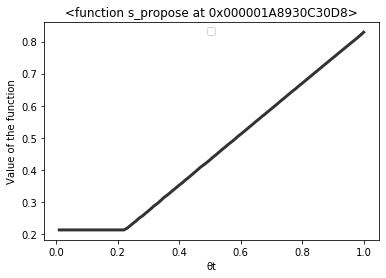

No handles with labels found to put in legend.


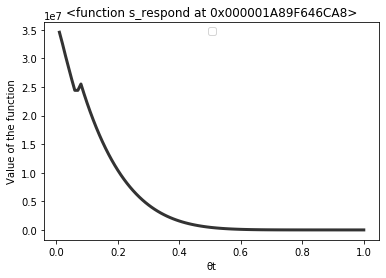

In [72]:
# graf_func(θs_vals, 1, 's', s_W)
graf_func(θs_vals, 1, 's', s_propose)
graf_func(θs_vals, 1, 's', s_respond)

No handles with labels found to put in legend.


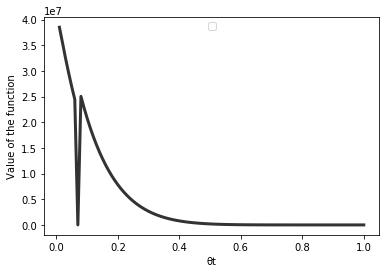

In [83]:
#gráfico da função valor

def graf_func_value(k_array):
    #true hability increases while lower bounds stay at 0.5
    #t is also endogenous 
    
    fig, ax = plt.subplots()

    #size of X axis
    X = θs_vals


    #storing the function vals in t
    graf_vals = k_array


    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")


    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()
    
graf_func_value(s_W[:, 1,1, 0])

In [85]:
s_W[:, 1,1, 0][0] #tá errado



38498116.15677773

In [77]:
#gráfico das propostas

def graf_proposal(function, function_name, t, xlabel, ylabel):
    

    grid_graf = len(θs_vals)

    graf = np.empty((grid_graf, grid_graf))

    for i, θs in enumerate(θs_vals):
        for j, lj in enumerate(lj_vals):
            graf[i,j] = function(θs, θs, lj, t)[1]


    fig, ax = plt.subplots()

    cs1 = ax.contourf(θs_vals, lj_vals, graf.T, alpha=0.75)
    # ctr1 = ax.contour(θs_vals, lj_vals, graf1.T)
    # plt.clabel(ctr1, inline=1, fontsize=13)
    plt.colorbar(cs1, ax = ax)

    ax.set_title('Function ' + function_name +   ' in period ' + str(t) )
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    ax.ticklabel_format(useOffset=False)


    plt.show()

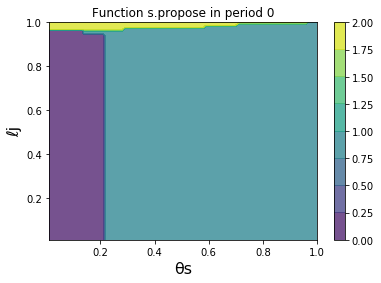

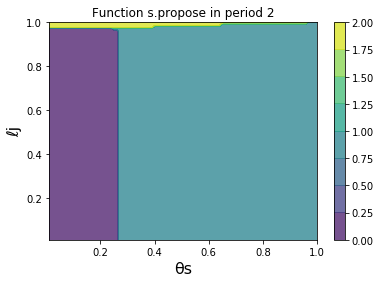

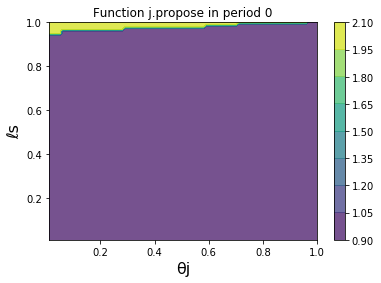

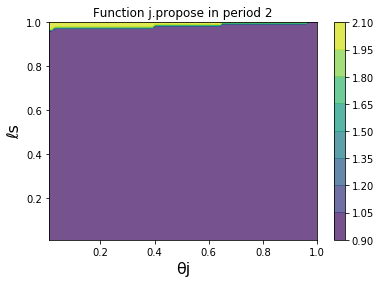

In [78]:
graf_proposal(s_propose,'s.propose', 0, 'θs', 'ℓj')

graf_proposal(s_propose,'s.propose', 2, 'θs', 'ℓj')

graf_proposal(j_propose, 'j.propose', 0, 'θj', 'ℓs')
graf_proposal(j_propose, 'j.propose', 2, 'θj', 'ℓs')

In [79]:
#gráfico das propostas

def graf_proposal2(function, function_name, t, xlabel, ylabel):
    #tentei plt.imshow() e não funfou

    grid_graf = len(θs_vals)

    graf = np.empty((grid_graf, grid_graf))

    for i, θs in enumerate(θs_vals):
        for j, lj in enumerate(lj_vals):
            graf[i,j] = function(θs, θs, lj, t)[1]


    fig, ax = plt.subplots()

#     cs1 = ax.contourf(θs_vals, lj_vals, graf.T, alpha=0.75)
    # ctr1 = ax.contour(θs_vals, lj_vals, graf1.T)
    # plt.clabel(ctr1, inline=1, fontsize=13)
#     plt.colorbar(cs1, ax = ax)

    ax.set_title('Function ' + function_name +   ' in period ' + str(t) )
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

#     ax.ticklabel_format(useOffset=False)
    
    
#     rgb = plt.get_cmap('jet')(graf)
#     ax.scatter(θs_vals, ℓs_vals, color = graf)

    # make a color map of fixed colors
#     cmap = mpl.colors.ListedColormap(['black', 'blue', 'red'])
#     bounds=[0,2]
#     norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


#     # tell imshow about color map so that only set colors are used
#     img = plt.imshow(graf.T,interpolation='nearest',
#                     cmap = cmap)
    
    
#     # make a color bar
#     plt.colorbar(img,cmap=cmap,boundaries=bounds,ticks=[0,1,2])

#     cmap = mpl.colors.ListedColormap(['black','blue', 'red'])
    plt.pcolor(θs_vals, θs_vals, graf.T, edgecolors='white', linewidths=0.01)


    plt.show()

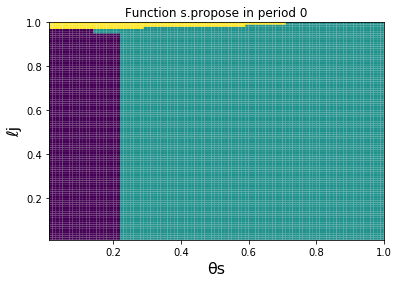

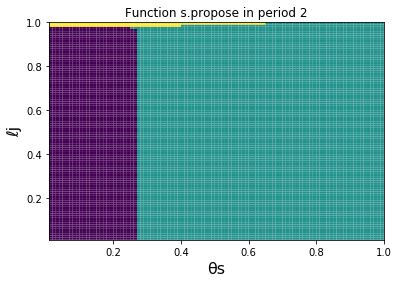

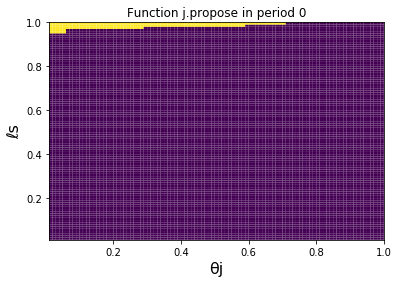

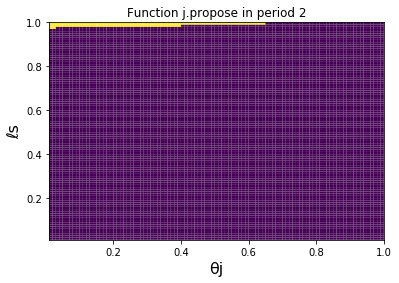

In [80]:
graf_proposal2(s_propose,'s.propose', 0, 'θs', 'ℓj')

graf_proposal2(s_propose,'s.propose', 2, 'θs', 'ℓj')

graf_proposal2(j_propose, 'j.propose', 0, 'θj', 'ℓs')
graf_proposal2(j_propose, 'j.propose', 2, 'θj', 'ℓs')

# Passo 5: resolvendo a negociação entre os credores

Aqui vamos resolver o jogo de fato.

Etapas:

1. Os dois credores recebem suas habilidades, que são informação privada
2. Um credor é sorteado para propor o que fazer com a firma
3. Há uma atualização nos lower bounds das habilidades para o próximo período
4. Usando os lower bounds do próximo período, o credor propositor faz uma oferta baseado no valor de continuação esperado para o próximo período (o dele próprio e o do adversário)
5. Há uma atualização das habilidades verdadeiras para o próximo período, que são informação privada
6. O credor respondente olha a sua habilidade para o próximo período, os lower bounds do próximo período, calcula seu valor de continuação do próximo período e dá uma resposta.
4. O jogo acaba quando os dois concordam quanto ao que fazer com a firma


O resultado final é um vetor contendo 3 coisas:
1. A taxa de recuperação de crédito (o quanto cada credor recebeu em relação ao que ele tinha de crédito)
2. Em qual turno a negociação acabou
3. O que decidiram fazer com a firma (reorganizar ou liquidar)



#### Barganha completa: com s ou j propondo

In [ ]:
#loop while resultado[3] diferente de t, continua



#parâmetros iniciais
t = 0

θst = θ_s0
θjt = θ_j0

#assumindo que lower bounds nos períodos iniciais são as próprias habilidades iniciais
lst = θ_s0
ljt = θ_j0


#vetor com payoff de s, payoff de j, destino da firma e período
#destino da firma é 0 (liquidou) ou 1 (reorganizou)
resultado = np.zeros(4)


#loop roda enquanto não encerrarem o jogo
#o payoff dos jogadores só é gravado no resultado o jogo acaba. 
#Então o loop vai rodar até que o payoff seja diferente do valor inicial, que é zero
while(resultado[0] == 0):
    




    #sorteio do jogador proponente

    u = uniform(0, 1)

    if(u < λj):
        propositor = 'j'

    else:
        propositor = 's'



    if(propositor == 's'):
        



        # se s é chamado a propor ####

        #proposta
        # 0 é liquidar
        # 1 é reorganizar
        # 2 é esperar

        proposta = St(θst, lst, ljt, t)[1]

        payoff_s = St(θst, lst, ljt, t)[0]

        #update dos lower bounds
        ls_next = St(θst, lst, ljt, t)[2]

        #lj_next não pode alterar caso a proposta seja de espera, pois não há cutoff
        lj_next = St(θst, lst, ljt, t)[3]


        #jeito resumido
        # [payoff_s, proposta, ls_next, lj_next] = St(θst, lst, ljt, 0)[1:]

        #update das habilidades à tarde
        θs_next = round(draw_beta(θst), 2)
        θj_next = round(draw_beta(θjt), 2)



        if(proposta == 0):

            #o que j faz se s propor liquidar?
            #j olha sua habilidade e os lower bounds do próximo período e calcula o valor de continuação
            #aqui ele olha o valor de continuação dele de fato, sem ser valor esperado. Então a função é diferente de j_liq

            jt_liq_valor = [Lj(t), V[t] * θj_next - Ls(t) ]

            resposta = np.argmax(jt_liq_valor)

            payoff_j = jt_liq_valor[resposta]


            if(resposta == 0):
                #j concorda em liquidar
                #payoffs são os de liquidação

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 0 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #j prefere reorganizar
                #payoff de s é liq, payoff de j é de reorganização

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #1 é caso reorganize
                resultado[3] = t 

            #em qualquer cenário, quando o oponente propôe liquidar o jogo acaba. Por isso sempre temos resultado[3] = t

        if(proposta == 1):
            #o que j faz se s propor reorganizar?

            #a proposta de pagamento de s é o valor esperado da função valor de j, com base nas informações que s tem hoje
            Pst = Ewj(expec_beta(lj_next), ls_next, lj_next, t+1)

            jt_reorg_valor = [Pst, Ewj(θj_next, ls_next, lj_next, t+1)]

            resposta = np.argmax(jt_reorg_valor)

            payoff_j = jt_reorg_valor[resposta]



            if(resposta == 0):
                #j concorda com a proposta de pagamento

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #j recusa a proposta de pagamento
                #jogo vai para o próximo período
                #vai para o próximo período

                t += 1

                #update das informações
                θst = θs_next
                θjt = θj_next
                lst = ls_next
                ljt = lj_next


        if(proposta == 2):
            #o que acontece se s propor esperar?
            #vai para o próximo período

            t += 1

            #update das informações
            θst = θs_next
            θjt = θj_next
            lst = ls_next
            #ljt não sofre alteração na proposta de esperar


    #============================================================================
    else: #caso quem proponha seja j


        # se j é chamado a propor ####

        #proposta
        # 0 é liquidar
        # 1 é reorganizar
        # 2 é esperar

        proposta = Jt(θst, lst, ljt, t)[1]

        payoff_j = Jt(θst, lst, ljt, t)[0]

        #update dos lower bounds
        ls_next = Jt(θst, lst, ljt, t)[2]

        #ls_next não pode alterar caso a proposta seja de espera, pois não há cutoff
        lj_next = Jt(θst, lst, ljt, t)[3]


        #jeito resumido


        #update das habilidades à tarde
        θs_next = round(draw_beta(θst), 2)
        θj_next = round(draw_beta(θjt), 2)



        if(proposta == 0):

            #o que j faz se s propor liquidar?
            #j olha sua habilidade e os lower bounds do próximo período e calcula o valor de continuação
            #aqui ele olha o valor de continuação dele de fato, sem ser valor esperado. Então a função é diferente de j_liq

            st_liq_valor = [Ls(t), V[t] * θs_next - Lj(t) ]

            resposta = np.argmax(st_liq_valor)

            payoff_s = st_liq_valor[resposta]


            if(resposta == 0):
                #j concorda em liquidar
                #payoffs são os de liquidação

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 0 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #j prefere reorganizar
                #payoff de s é liq, payoff de j é de reorganização

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #1 é caso reorganize
                resultado[3] = t 

            #em qualquer cenário, quando o oponente propôe liquidar o jogo acaba. Por isso sempre temos resultado[3] = t

        if(proposta == 1):
            #o que s faz se j propor reorganizar?

            Pjt = Ews(expec_beta(ls_next), ls_next, lj_next, t+1)

            st_reorg_valor = [Pjt, Ews(θs_next, ls_next, lj_next, t+1)]

            resposta = np.argmax(st_reorg_valor)

            payoff_s = st_reorg_valor[resposta]



            if(resposta == 0):
                #s concorda com a proposta de pagamento

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #s recusa a proposta de pagamento
                #jogo vai para o próximo período

                t += 1

                #update das informações
                θst = θs_next
                θjt = θj_next
                lst = ls_next
                ljt = lj_next


        if(proposta == 2):
            #o que acontece se s propor esperar?
            #vai para o próximo período

            t += 1

            #update das informações
            θst = θs_next
            θjt = θj_next
            ljt = lj_next
            #lst não sofre alteração na proposta de esperar


In [ ]:
θst
θjt

resultado

proposta

t
propositor

#agora falta fazer a média dos valores de negociação para colocar como um momento



# Próximos passos



* HIGIENIZAR O CÓDIGO, DEIXAR ORGANIZADO!


* ~debugar o que acontece quando t = 14~
    * bug na função pmf, e acho que vem da função bins() também


* ~criar função de esperança baseada na função beta~
    * expec_beta(info_hoje) retorna o valor esperado de teta amanhã




* ~discretizar a beta para obter a esperança das funções valor no período seguinte~



* ~fazer Js_val~

* ~guardar resultados de Js_val e Ws_val do último período numa  matriz 4D~

* ~pensar numa função Js_next para achar o valor de Js no próximo período baseado nos parâmetros deste período~
    * regra para atualização de lst
    * regra para atualização de ljt
    * expectativa da habilidade no período seguinte

* ~pensar na forma recursiva do jogo~
    * acho que as funções probabilidade também têm que considerar o update do lower bound, pois elas fazem parte do cenário onde o jogador não propõe


* checar todas as funções de cálculo do jogo (Passo 3)


* considerar a estrutura de negociação do jogo

* aumentar a precisão das estimativas do jogo
    * algoritmo para cálculo do cutoff pode ter mais casas decimais
    
    
 * fazer uma estrutura mais enxuta, com uma função que tome como argumento se é s ou j. Ao invés de criar St, Jt, st, jt...
    


* passos finais
    * replicar os gráficos do artigo de referência


### Conferir novamente

1. ~Se preciso usar ls_next e lj_next nas funções Prob_s e Prob_j~ 
   * conferi e precisa sim, já arrumei

2. Se o valor esperado da função para calcular os thresholds cst e cjt estão corretos

3. A função pmf não está somando um, tem que verificar onde está o erro

